In [2]:
import mmf_setup;mmf_setup.nbinit(hgroot=False)

<IPython.core.display.Javascript object>

# Mixed Dimension Pairing

Here we implement the BdG equations for a Fermi gas with one component in an optical lattice.  The claim is that with the following dispersions, one can have a very high $T_c$:

$$
  \epsilon_k^{\uparrow} = \frac{k_\perp^2}{2m} + 2t[1-\cos(k_z d)] - \mu_\uparrow, \qquad
  \epsilon_k^{\downarrow} = \frac{k^2}{2m} - \mu_\downarrow.
$$

The dispersion relationship here is a bit of a misnomer.  There low-energy states are just the single Bloch band $\abs{k_z} \leq \pi/d$.  The other bands are much higher separated by a large gap.

The BdG equations follow from the single-particle Hamiltonian (assuming homogeneous states)

$$
  \begin{pmatrix}
    \epsilon_k^{\uparrow} & \Delta\\
    \Delta & -\epsilon_k^{\downarrow}
  \end{pmatrix}
$$

which has eigenvectors and eigenvalues

$$
  \omega_{\pm} = \epsilon^{-}_k \pm E_k, \qquad
  E_k = \sqrt{(\epsilon^{+}_k)^2 + \Delta^2}, \\
  \epsilon^{\pm}_{k} = \frac{\epsilon^\uparrow_k \pm \epsilon^\downarrow_k}{2}\\
  u_k^2 = \frac{1+\epsilon^+_k/E_k}{2}, \qquad
  v_k^2 = \frac{1-\epsilon^+_k/E_k}{2},\\
  n_+ = 1 - \frac{\epsilon^+_k}{2E_k}\left[\tanh(\beta\omega_+/2) - \tanh(\beta\omega_-/2)\right], \qquad
  n_- = - \frac{1}{2}\left[\tanh(\beta\omega_+/2) + \tanh(\beta\omega_-/2)\right]\\
  \Delta = -g\int \frac{\d^{3}\vect{k}}{(2\pi)^3}\frac{\Delta}{2E_k}\frac{\left[\tanh(\beta\omega_+/2) - \tanh(\beta\omega_-/2)\right]}{2}
$$

Equation (3) from the paper follows from $\tanh(\beta\omega/2) = 1 - 2f_\beta(\omega)$:

$$
  n_- = 0 = \sum_{k}\Bigl[f_\beta(\omega_+) - f_\beta(-\omega_-)\Bigr]\\
  n_+ = \sum_{k}\left(
    1 + \frac{\epsilon^+_k}{E_k}
    \left[f_\beta(\omega_+) + f_\beta(-\omega_-) - 1\right]
  \right)
      = \sum_{k}\left(
    2v_k^2 
    + \frac{\epsilon^+_k}{E_k}\left[f_\beta(\omega_+) + f_\beta(-\omega_-)\right]
  \right),\\
  g^{-1} = \frac{m}{4\pi a} - \sum_{k} \frac{1}{2\epsilon_k^+} = -\sum_{k}
  \frac{1 - f_\beta(\omega_+) - f_\beta(-\omega_-)}{2E_k}\\
  \frac{m}{4\pi a} = \sum_{k}\left(
    \frac{1}{2\epsilon_k^+} - \frac{1 - f_\beta(\omega_+) - f_\beta(-\omega_-)}{2E_k}\right)\\
$$

$$
  \tanh(\beta\omega/2) = 1 - 2f_\beta(\omega), \qquad
  f_\beta(\omega) + f_\beta(-\omega) = 1.
$$

In [3]:
%pylab inline --no-import-all
from scipy.integrate import quad

hbar = m = 1
k_F = 1.0
E_F = (hbar*k_F)**2/2/m


class Solution(object):
    k_max = 100
    Nk = 1000
    T = 0.1*E_F 
    Delta = 22.5*E_F
    d = 50/k_F
    t = 0.1*E_F
    mu_a = 9.7*E_F
    mu_b = -12*E_F


    def __init__(self, **kw):
        self.__dict__.update(kw)
        self.k_perp = np.linspace(0, self.k_max, self.Nk)[None,:]
        self.k_z = np.linspace(-np.pi/self.d, np.pi/self.d, self.Nk+1)[:, None]
        self.dk_z = np.diff(self.k_z.ravel()).mean()

    def f(self, E):
        return 1./(1+np.exp(E/self.T))

    def get_es(self, k_perp):
        e_a = hbar**2*(k_perp**2 + self.k_z**2)/2/m - self.mu_a
        e_b = hbar**2*k_perp**2/2/m + 2*self.t*(1-np.cos(self.k_z*self.d)) - self.mu_b
        return (e_a, e_b)
        
    def n_integrand(self, k_perp):
        e_a, e_b = self.get_es(k_perp=k_perp)
        e_p = (e_a + e_b)/2
        e_m = (e_a - e_b)/2
        E = np.sqrt(e_p**2 + self.Delta**2)
        w_p = e_m + E
        w_m = e_m - E
        n_m = self.f(w_p) - self.f(-w_m)
        n_p = 1 + e_p/E*(self.f(w_p) + self.f(-w_m) - 1)
        return np.trapz(2*np.pi*k_perp*n_p.ravel(), self.k_z.ravel())/(2*np.pi)**3

    def dn_integrand(self, k_perp):
        e_a, e_b = self.get_es(k_perp=k_perp)
        e_p = (e_a + e_b)/2
        e_m = (e_a - e_b)/2
        E = np.sqrt(e_p**2 + self.Delta**2)
        w_p = e_m + E
        w_m = e_m - E
        n_m = self.f(w_p) - self.f(-w_m)
        return np.trapz(2*np.pi*k_perp*n_m.ravel(), self.k_z.ravel())/(2*np.pi)**3

    def nu_integrand_(self, k_perp):
        e_a, e_b = self.get_es(k_perp=k_perp)
        e_p = (e_a + e_b)/2
        e_m = (e_a - e_b)/2
        E = np.sqrt(e_p**2 + self.Delta**2)
        w_p = e_m + E
        w_m = e_m - E
        n_m = self.f(w_p) - self.f(-w_m)
        n_p = 1 + e_p/E*(self.f(w_p) + self.f(-w_m) - 1)
        mu_p = (self.mu_a + self.mu_b)/2
        nu = 1./2./(e_p + mu_p) - (1 - self.f(w_p) - self.f(-w_m))/2/E
        return 2*np.pi*k_perp*nu/(2*np.pi)**3

    def nu_integrand(self, k_perp):
        return np.trapz(self.nu_integrand_(k_perp).ravel(), self.k_z.ravel())

    def solve(self):
        """Return (k_F, dn/n, 1./akF)"""
        n = quad(self.n_integrand, 0, self.k_max)[0]
        dn = quad(self.dn_integrand, 0, self.k_max)[0]
        k_F = (3*np.pi**2*n)**(1./3)
        akF_inv = 4*np.pi * quad(self.nu_integrand, 0, self.k_max)[0]/ m/k_F
        return k_F, dn/n, akF_inv
    
class SolutionBCS_(Solution):
    def __init__(self, **kw):
        Solution.__init__(self, **kw)
        self.k_z = np.linspace(-self.k_max, self.k_max, self.Nk+1)[:, None]
        self.dk_z = np.diff(self.k_z.ravel()).mean()

    def get_es(self, k_perp):
        e_a = hbar**2*(k_perp**2 + self.k_z**2)/2/m - self.mu_a
        e_b = hbar**2*(k_perp**2 + self.k_z**2)/2/m - self.mu_b
        return (e_a, e_b)

Populating the interactive namespace from numpy and matplotlib


In [29]:
from IPython.display import clear_output
from scipy.optimize import fsolve

d = 50/k_F
akF_inv = 0.1093561

Delta0 = 22.5*E_F
T_c = 0.96*E_F

def f_T(q):
    display(q)
    clear_output(wait=True)
    T, mu_a, mu_b = np.asarray(q)*E_F

    sol = Solution(
        T=T,
        Delta=0.0,
        d=d,
        mu_a=mu_a, mu_b=mu_b)
    return np.array(sol.solve()) - (1.0, 0.0, akF_inv)

def f_D(q):
    display(q)
    clear_output(wait=True)
    Delta, mu_a, mu_b = np.asarray(q)*E_F

    sol = Solution(
        T=0.0001*E_F, 
        Delta=Delta,
        d=d,
        mu_a=mu_a, mu_b=mu_b)
    return np.array(sol.solve()) - (1.0, 0.0, akF_inv)

q_T = (T_c/E_F, 0.3, 0.3)
q_T = fsolve(f_T, q_T)

q_D = (Delta0/E_F, 1.0, 1.0)
q_D = fsolve(f_D, q_D)
print(q_T)
print(q_D)

[14.18331303  1.50448197  1.70283026]
[22.44711387 -3.30205792  1.        ]


In [5]:
q_T = (0.1, 9.6, -12)
#q_T = fsolve(f_T, q_T)
q_D = (22.5, 9.6, -12.)
q_D = fsolve(f_D, q_D)
print(q_T)
print(q_D)
    

(0.1, 9.6, -12)
[ 22.50000362   9.61898799 -12.        ]


In [6]:
def f_T(q):
    display(q)
    clear_output(wait=True)
    T, mu_a, mu_b = np.asarray(q)*E_F
    #Delta, mu_a, mu_b = np.asarray(q)*E_F

    sol = Solution(
        T=T,
        Delta=20*E_F,
        d=d,
        mu_a=mu_a, mu_b=mu_b)
    return np.array(sol.solve()) - (1.0, 0.0, akF_inv)

def f_D(q):
    display(q)
    clear_output(wait=True)
    Delta, mu_a, mu_b = np.asarray(q)*E_F

    sol = Solution(
        T=1.1*E_F, 
        Delta=Delta,
        d=d,
        mu_a=mu_a, mu_b=mu_b)
    return np.array(sol.solve()) - (1.0, 0.0, akF_inv)

In [7]:
class SolutionBCS(object):
    k_max = 100
    Nk = 1000
    T = 0.1*E_F 
    Delta = 22.5*E_F
    d = 50/k_F
    t = 0.1*E_F
    mu_a = 9.7*E_F
    mu_b = -12*E_F


    def __init__(self, **kw):
        self.__dict__.update(kw)
        self.k_perp = np.linspace(0, self.k_max, self.Nk)[None,:]
        self.k_z = np.linspace(-np.pi/self.d, np.pi/self.d, self.Nk+1)[:, None]
        self.dk_z = np.diff(self.k_z.ravel()).mean()

    def f(self, E):
        return 1./(1+np.exp(E/self.T))

    def get_es(self, k):
        e_a = hbar**2*k**2/2/m - self.mu_a
        e_b = hbar**2*k**2/2/m - self.mu_b
        return (e_a, e_b)
        
    def n_integrand(self, k):
        e_a, e_b = self.get_es(k=k)
        e_p = (e_a + e_b)/2
        e_m = (e_a - e_b)/2
        E = np.sqrt(e_p**2 + self.Delta**2)
        w_p = e_m + E
        w_m = e_m - E
        n_m = self.f(w_p) - self.f(-w_m)
        n_p = 1 + e_p/E*(self.f(w_p) + self.f(-w_m) - 1)
        return 4*np.pi*k**2*n_p/(2*np.pi)**3

    def dn_integrand(self, k):
        e_a, e_b = self.get_es(k=k)
        e_p = (e_a + e_b)/2
        e_m = (e_a - e_b)/2
        E = np.sqrt(e_p**2 + self.Delta**2)
        w_p = e_m + E
        w_m = e_m - E
        n_m = self.f(w_p) - self.f(-w_m)
        return 4*np.pi*k**2*n_m/(2*np.pi)**3

    def nu_integrand(self, k):
        e_a, e_b = self.get_es(k=k)
        e_p = (e_a + e_b)/2
        e_m = (e_a - e_b)/2
        E = np.sqrt(e_p**2 + self.Delta**2)
        w_p = e_m + E
        w_m = e_m - E
        n_m = self.f(w_p) - self.f(-w_m)
        n_p = 1 + e_p/E*(self.f(w_p) + self.f(-w_m) - 1)
        mu_p = (self.mu_a + self.mu_b)/2
        nu = 1./2./(e_p + mu_p) - (1 - self.f(w_p) - self.f(-w_m))/2/E
        return 4*np.pi*k**2*nu/(2*np.pi)**3

    def solve(self):
        """Return (k_F, dn/n, 1./akF)"""
        n = quad(self.n_integrand, 0, self.k_max)[0]
        dn = quad(self.dn_integrand, 0, self.k_max)[0]
        k_F = (3*np.pi**2*n)**(1./3)
        akF_inv = 4*np.pi * quad(self.nu_integrand, 0, self.k_max)[0]/ m/k_F
        return k_F, dn/n, akF_inv

In [8]:
SolutionBCS = SolutionBCS

Delta0 = 0.6864*E_F
T_c = 0.5*E_F

def f_T(q):
    display(q)
    clear_output(wait=True)
    T, mu_a, mu_b = np.asarray(q)*E_F

    sol = SolutionBCS(
        T=T,
        Delta=0.0,
        d=d,
        mu_a=mu_a, mu_b=mu_b)
    return np.array(sol.solve()) - (1.0, 0.0, 0)

def f_D(q):
    display(q)
    clear_output(wait=True)
    Delta, mu_a, mu_b = np.asarray(q)*E_F

    sol = SolutionBCS(
        T=0.0001*E_F, 
        Delta=Delta,
        d=d,
        mu_a=mu_a, mu_b=mu_b)
    return np.array(sol.solve()) - (1.0, 0.0, 0)

q_T = (T_c/E_F, 0.3, 0.3)
q_T = fsolve(f_T, q_T)

q_D = (1.5, 1.0, 1.0)
q_D = fsolve(f_D, q_D)
print(q_T)
print(q_D)


[0.49368909 0.7498913  0.7498913 ]
[0.68560168 0.18958219 1.        ]


# Mathieu’s equation

Mathiue's eqaution is written as:
$y''+(\lambda-2h^2cos(2x))y=0$

Python document on Mathieus's equations：https://docs.scipy.org/doc/scipy/reference/special.html#mathieu-and-related-functions

In [10]:
s0.k_perp.shape

NameError: name 's0' is not defined

In [11]:
#plt.plot(s0.k_perp.ravel(), list(map(s0.nu_integrand, s0.k_perp.ravel())))
#quad(s0.nu_integrand, 0.000001, s0.k_max)[0]
k2 = s0.k_z**2 + s0.k_perp**2
plt.loglog(k2.ravel(), s0.nu_integrand_(s0.k_perp).ravel(), '+')

NameError: name 's0' is not defined

In [12]:
s0 = SolutionBCS_(k_max=10.0, T=0.0001*E_F, Delta=Delta0, mu_a=0.18958219*E_F, mu_b=1.0*E_F)
s1 = SolutionBCS(T=0.0001*E_F, Delta=Delta0, mu_a=0.18958219*E_F, mu_b=1.0*E_F)
s0.solve(), s1.solve()


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in true_divide
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


((0.9908771797172861, 0.0, inf),
 (1.000331196495867, 0.0, 0.0005353381849227983))

In [13]:
T_c/E_F

0.5

In [14]:
f_D((0.01, 2.0, 2.0))

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


array([ 0.41424825,  0.        , -3.41450648])

In [15]:
from scipy.integrate import quad
n = quad(n_integrand, 0, k_max)[0]
dn = quad(dn_integrand, 0, k_max)[0]
k_F = (3*np.pi**2*n)**(1./3)
akF_inv = 4*np.pi * quad(nu_integrand, 0, k_max)[0]/ m/k_F
k_F, dn/n, akF_inv

NameError: name 'n_integrand' is not defined

In [16]:
# Maximum T_c ~ 0.95
# kd = 50
# t/E_F = 0.1
# Delta = 22.5*E_F
# mu_a = 9.6*E_F
# mu_b = -12.6*E_F
# 1/ka_eff =4.6
# a/a_eff = 42
# 1/ka = 4.6/42 = 0.11

### Values for T=0
sol0 = Solution(
    t=0.1*E_F, 
    T=1e-12*13.1*E_F, 
    Delta=22.5*E_F, 
    d=50/k_F,
    mu_a=9.7*E_F,
    mu_b=-12.1*E_F)
#sol0 = Solution()
sol0.solve()

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp


(0.999859367724387, 0.0, 0.10937988542659587)

In [17]:

def nu_integrand(k_perp, k_z=k_z):
    e_a = hbar**2*(k_perp**2 + k_z**2)/2/m - mu_a
    e_b = hbar**2*k_perp**2/2/m + 2*t*(1-np.cos(k_z*d)) - mu_b
    e_b = e_a
    e_p = (e_a + e_b)/2
    e_m = (e_a - e_b)/2
    E = np.sqrt(e_p**2 + Delta**2)
    w_p = e_m + E
    w_m = e_m - E
    n_m = f(w_p) - f(-w_m)
    n_p = 1 + e_p/E*(f(w_p) + f(-w_m) - 1)
    nu = 1./2./(e_p + mu_p) - (1-f(w_p) - f(-w_m))/2/E
    return np.trapz(2*np.pi*k_perp*nu.ravel(), k_z.ravel())

from scipy.integrate import quad
akF_inv = 4*np.pi * quad(nu_integrand, 0, k_max)[0]/ m/k_F
akF_inv

NameError: name 'k_z' is not defined

In [18]:
# Standard BCS theory
%pylab inline --no-import-all

def f(E):
    return 1./(1+np.exp(beta*E))

k_max = 100
hbar = m = 1
k_F = 1.0
E_F = (hbar*k_F)**2/2/m
T = 0.001*E_F 
beta = 1./T
Delta = 0.686*E_F
mu_p = 0.298

def n_integrand(k):
    e_a = e_b = hbar**2*(k**2)/2/m - mu_p
    e_p = (e_a + e_b)/2
    e_m = (e_a - e_b)/2
    E = np.sqrt(e_p**2 + Delta**2)
    w_p = e_m + E
    w_m = e_m - E
    n_m = f(w_p) - f(-w_m)
    n_p = 1 + e_p/E*(f(w_p) + f(-w_m) - 1)
    return 4*np.pi * k**2 * n_p/(2*np.pi)**3

def nu_integrand(k):
    e_a = e_b = hbar**2*(k**2)/2/m - mu_p
    e_p = (e_a + e_b)/2
    e_m = (e_a - e_b)/2
    E = np.sqrt(e_p**2 + Delta**2)
    w_p = e_m + E
    w_m = e_m - E
    n_m = f(w_p) - f(-w_m)
    n_p = 1 + e_p/E*(f(w_p) + f(-w_m) - 1)
    nu = 1./2./(e_p + mu_p) - (1-f(w_p) - f(-w_m))/2/E
    return 4*np.pi * k**2 * nu/(2*np.pi)**3

from scipy.integrate import quad
n = quad(n_integrand, 0, k_max)[0]
k_F = (3*np.pi**2*n)**(1./3.)
print(k_F)
akF_inv = 4*np.pi * quad(nu_integrand, 0, k_max)[0]/ m/k_F
print(akF_inv)

Populating the interactive namespace from numpy and matplotlib
1.0006020598135117
-0.0006634975279849959


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


In [19]:
#Standard BCS theory in cylidrical 
%pylab inline --no-import-all

def f(E):
    return 1./(1+np.exp(beta*E))

k_max = 100
hbar = m = 1
k_F = 1.0
E_F = (hbar*k_F)**2/2/m
T = 0.001*E_F 
beta = 1./T
Delta = 0.686*E_F
mu_p = 0.298

k_z = np.linspace(-k_max, k_max, 1000)[:, None]

def n_integrand(k_perp, k_z=k_z):
    e_a = e_b = hbar**2*(k_perp**2 + k_z**2)/2/m - mu_p
    e_p = (e_a + e_b)/2
    e_m = (e_a - e_b)/2
    E = np.sqrt(e_p**2 + Delta**2)
    w_p = e_m + E
    w_m = e_m - E
    n_m = f(w_p) - f(-w_m)
    n_p = 1 + e_p/E*(f(w_p) + f(-w_m) - 1)
    return np.trapz(2*np.pi*k_perp*n_p.ravel(), k_z.ravel())/(2*np.pi)**3

def nu_integrand(k_perp, k_z=k_z):
    e_a = e_b = hbar**2*(k_perp**2 + k_z**2)/2/m - mu_p
    e_p = (e_a + e_b)/2
    e_m = (e_a - e_b)/2
    E = np.sqrt(e_p**2 + Delta**2)
    w_p = e_m + E
    w_m = e_m - E
    n_m = f(w_p) - f(-w_m)
    n_p = 1 + e_p/E*(f(w_p) + f(-w_m) - 1)
    nu = 1./2./(e_p + mu_p) - (1-f(w_p) - f(-w_m))/2/E
    return np.trapz(2*np.pi*k_perp*nu.ravel(), k_z.ravel())/(2*np.pi)**3

from scipy.integrate import quad
n = quad(n_integrand, 0, k_max)[0]
k_F = (3*np.pi**2*n)**(1./3)
akF_inv = 4*np.pi * quad(nu_integrand, 0, k_max)[0]/ m/k_F
k_F, akF_inv

Populating the interactive namespace from numpy and matplotlib


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


(1.0007281191052995, -0.045209357956725954)

In [20]:
Delta/E_F

0.686

NameError: name 'n_m' is not defined

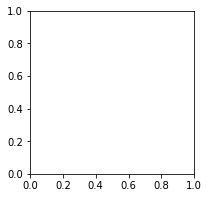

In [21]:
#plt.plot(k_z, e_a, k_z, e_b)
#plt.axhline(E_F)
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.plot(k_z[:,0], n_m[:,:])
plt.subplot(132)
plt.plot(k_perp[0,:], n_p[:,:].T)
plt.subplot(133)
#plt.plot(k_perp[0,:], nu[:,:].T);
plt.plot(k_z[:,0], nu[:,0]);

In [22]:
metric = 2*np.pi*k_perp[None,:]/(2*np.pi)**3*np.diff(k_perp.ravel())[0]*np.diff(k_z.ravel())[0]
N_p = (metric*n_p).sum()
N_m = (metric*n_m).sum()
ainv = 4*np.pi*(metric*nu).sum()/m
ainv/k_F

NameError: name 'k_perp' is not defined

Populating the interactive namespace from numpy and matplotlib


c:\program files\python36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'beta']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


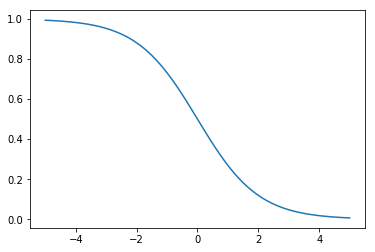

In [23]:
%pylab inline
x = np.linspace(-5,5,100)
plt.plot(x, 1/(1+exp(x)))

6.0


c:\program files\python36\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


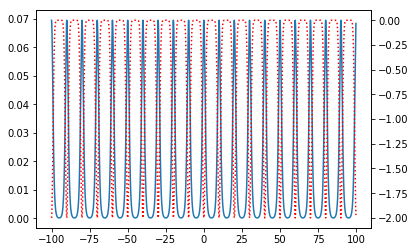

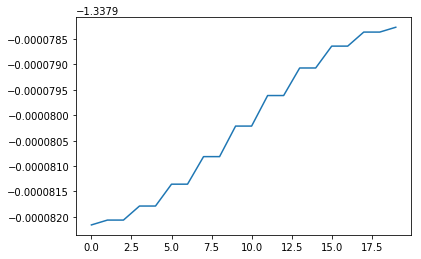

In [24]:
cells = 20
N = 64*cells
L = 10.0*cells
r0 = 1.0
p = np.ceil(L**2/2/r0**2/cells**2/np.pi**2/2)*2
print(p)
V0 = -2.0
dx = L/N
x = np.arange(N)*dx - L/2
k = 2*np.pi * np.fft.fftfreq(N, dx)
V = V0 *(((1+np.cos(2*np.pi*cells*x/L))/2)**p)
#V = V0*sum(np.exp(-(x-n*L/cells)**2/2/r0**2) for n in range(-cells, cells))
Q = np.exp(1j*k[:,None]*x[None,:])
K = Q.T.conj().dot(k[:,None]**2/2 * Q)/N
H = K + np.diag(V)
d, psi = np.linalg.eigh(H)
plt.plot(x, psi[:,0])
plt.twinx()
plt.plot(x, V, 'r:')
plt.figure()
plt.plot(d[:cells])

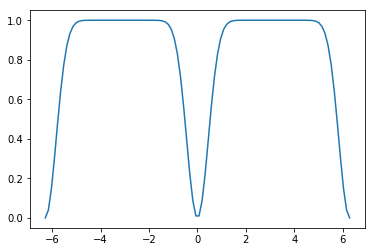

In [25]:
x = np.linspace(-2*np.pi, 2*np.pi, 100)
plt.plot(x, 1-((1+cos(x))/2)**10)


# Band

$$
  t = 0.1E_F, \qquad
  d \sim 10/k_F, \qquad 
  d_\max = 50/k_F,
  t = 0.1\frac{(10/d)^2}{2} = \frac{5}{d^2}
$$

The Lattice potential admits an exact solution in terms of Mathier fuctions and the single-band model is appropriate when $h>2$:

$$
  \frac{\op{p}^2}{2m} + \frac{V_0}{2}\cos(2k_0x),
  \qquad
  L = \frac{\pi}{k_0}, \qquad
  E_R = \frac{\hbar^2 k_0^2}{2m}, \qquad
  4h^2 = \frac{V_0}{E_R}, \qquad
  \lambda = \frac{E}{E_R},\\
  E(k) = E_0 + 2t\cos(kL) +\cdots, \qquad
  \frac{t}{E_R} = \frac{8\sqrt{2}}{\sqrt{\pi}}h^{3/2}e^{-4h}\left[1+\order(1/h)\right]
$$

http://iopscience.iop.org/article/10.1088/1361-6404/aa8d2c/meta

In [26]:
0.1*(3/np.pi)**2

0.091189065278104

In [27]:
t_ER(1)

NameError: name 't_ER' is not defined

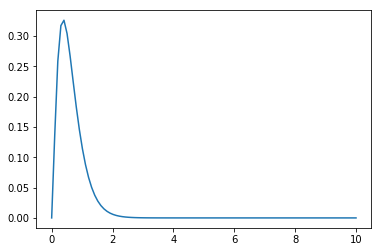

In [59]:
h = np.linspace(0,10,100)
def t_ER(h):
    return 8*np.sqrt(2/np.pi)*h**(3./2)*np.exp(-4*h)

plt.plot(h, t_ER(h))

## Kronig–Penney model

The dispersion relation for the Kronig-Penney Model(see https://en.wikipedia.org/wiki/Particle_in_a_one-dimensional_lattice) can be determined from the equations:
$$
cos(ka)=cos(\alpha a) + P\frac{sin(\alpha a)}{\alpha a}\\
P=\frac{mV_0ba}{\hbar^2}\\
\alpha^2 = \frac{2m\abs{E}}{\hbar^2}
$$

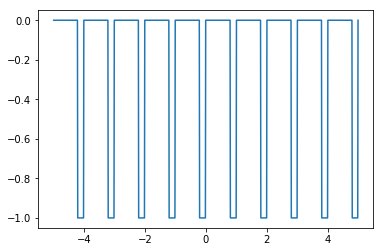

In [107]:
from scipy.optimize import brentq
a = 1.0
b = 0.2
m = 1.0
hbar = 1.0
V0 = -1.0
P = m * V0 * b * a / hbar**2

xs= np.linspace(-5,5,1000)
def PlotPotential(xs,v0, a, b):
    ys = [0.0 if ((int(x * 100.0 / a) % 100 + 100) % 100) / 100.0 < 1.0 - b else v0 for x in xs ]
    plt.plot(xs,ys)
PlotPotential(xs,V0,a,b)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


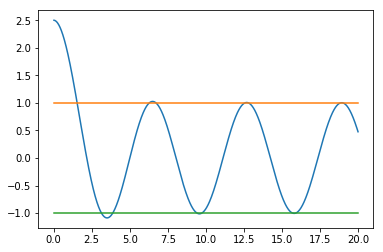

In [113]:
P = 1.5
ks = np.linspace(0,20, 1000)
def DispersionRHS(x):
    return  np.cos(x) + P * np.sin(x) / x;
plt.plot(ks, [DispersionRHS(x) for x in ks])
plt.plot(ks, [1 for x in ks])
plt.plot(ks, [-1 for x in ks])

In [ ]:
def Energy(k):
    def _lam(x):
        display(x)
        return np.cos(k*a) - DispersionRHS(x)
    alpha = brentq(_lam, 0.1, np.pi / 2) / a
    E = alpha**2 * 2.0 * m / hbar**2
    return E

def PlotBandStructure(n):
    Es = [Energy(k) for k in ks]
    plt.plot(ks, Es)